首先，这里需要获得对应H5AD数据集的对应genecompass编码，在genecompass生成编码的流程中，存在对于细胞和基因的筛选，这里需要获取其中选择对应细胞和基因的文件。并基于这两个文件，修改H5AD。

In [ ]:
import scanpy as sc
import numpy as np

aData = sc.read_h5ad('/home/ict/yzh/norman_already_pre/perturb_processed.h5ad')
print(aData)

link=list(aData.var['gene_name'].index)

from datasets import load_from_disk
import pickle
# 预处理保存的细胞序列
with open('/home/ict/yzh/cell.pkl','rb') as f:
    data=pickle.load(f)

choose=[]

for i in data:
    if i==True:
        choose.append(0)
    else:
        choose.append(1)

print(data)
print(sum(choose))

# 预处理提供的基因排序
with open('/home/ict/yzh/gene.pkl','rb') as f:
    gene_sort=pickle.load(f)

gene_token_path = '/home/ict/from_a800/public/human_mouse_tokens.pickle' #token路径，需要改

with open(gene_token_path,'rb') as f:
    gene_dic=pickle.load(f)

my_dic={value: key for key, value in gene_dic.items()}

gene_sort=np.array(gene_sort)

jihe=set()
for i in range(len(gene_sort)):
    for j in range(2048):
        jihe.add(gene_sort[i][j])
    break


yzh_layers=[]
for i in range(len(gene_sort)):
    mid=[]
    last=0
    for j in range(3040):
        mid.append(-1)
    for j in range(2048):
        if gene_sort[i][j]!=0:
            mid[link.index(my_dic[gene_sort[i][j]])]=j
        else:
            last=j
            break
    for j in range(3040):
        if mid[j]==-1:
            mid[j]=last
    yzh_layers.append(mid)

yzh_layers=np.array(yzh_layers)

with open('/home/ict/yzh/0324_work/my_gene_sort_layers.pickle','wb') as f:
    pickle.dump(yzh_layers,f)

生成新的对应的H5AD文件

In [ ]:
aData = sc.read_h5ad('/home/ict/yzh/norman_already_pre/perturb_processed.h5ad')

aData.obs['flag'] = range(len(aData.obs))

aData.layers['new_layers']=yzh_layers

aData.write('/home/ict/yzh/0324_work/yzh_file.h5ad')

然后就可以调用Gears的代码部分

执行之前需要调整一下Gears代码中的gears.py文件140行前后位置，调整对应的编码文件路径。

In [ ]:
from geares import PertData, GEARS
import numpy as np
import scanpy as sc
adata1 = sc.read_h5ad('../data/yzh_file.h5ad')

diaoyong_moxing_type='id_value_genefam'

# # get data
pert_data = PertData('./data')

# 如果是新的数据，需要执行下面这个new_data_process函数，生成对应的data
# pert_data.new_data_process(dataset_name = 'norman_by_new_propress', adata = adata1)
# # to load the processed data
pert_data.load(data_path = './data/norman_by_new_propress')

# # specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# # get dataloader with batch size
pert_data.get_dataloader(batch_size = 16, test_batch_size = 64)

# # set up and train a model
gears_model = GEARS(pert_data, device = 'cuda:0')
# 对应的使用大模型生成编码路径目录
gears_model.model_initialize(hidden_size = 64,damoxing_type=diaoyong_moxing_type)
gears_model.train(epochs = 10)

config_filename='config_'+diaoyong_moxing_type+'_'+'.pkl'
model_filename='model_'+diaoyong_moxing_type+'_'+'.pt'
print(config_filename,model_filename)

gears_model.save_model('model_folder',config_filename,model_filename)

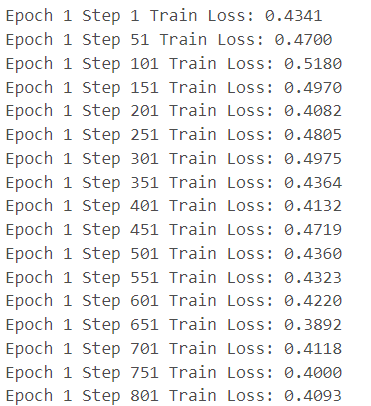